In [42]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [43]:
# 📂 1. Load ETTh2 Data from local file
file_path = "../data/raw/ETTh2.csv"

df_etth2 = pd.read_csv(file_path)

print("✅ ETTh2 dataset loaded from local file!")
print(df_etth2.head())

✅ ETTh2 dataset loaded from local file!
                  date       HUFL    HULL       MUFL   MULL   LUFL   LULL  \
0  2016-07-01 00:00:00  41.130001  12.481  36.535999  9.355  4.424  1.311   
1  2016-07-01 01:00:00  37.528000  10.136  33.936001  7.532  4.435  1.215   
2  2016-07-01 02:00:00  37.946999  11.309  35.330002  9.007  2.100  0.000   
3  2016-07-01 03:00:00  38.952000  11.895  35.543999  9.436  3.380  1.215   
4  2016-07-01 04:00:00  38.113998  11.476  35.410000  9.623  2.036  0.000   

          OT  
0  38.661999  
1  37.124001  
2  36.465000  
3  33.608501  
4  31.850500  


In [44]:
# 📜 2. Preprocessing
# ❗ IMPORTANT: These min and max values must be same as ETTh1 preprocessing min-max
# Update them according to your preprocessing!

file_path_etth1 = "../data/raw/ETTh1.csv"

df_etth1 = pd.read_csv(file_path_etth1)

# Get min and max for 'OT' column
min_OT = df_etth1['OT'].min()
max_OT = df_etth1['OT'].max()

df_etth2['OT'] = (df_etth2['OT'] - min_OT) / (max_OT - min_OT)

print("\n✅ Preprocessing applied (normalization)!")
print(df_etth2[['date', 'OT']].head())


✅ Preprocessing applied (normalization)!
                  date        OT
0  2016-07-01 00:00:00  0.853355
1  2016-07-01 01:00:00  0.822649
2  2016-07-01 02:00:00  0.809491
3  2016-07-01 03:00:00  0.752461
4  2016-07-01 04:00:00  0.717362


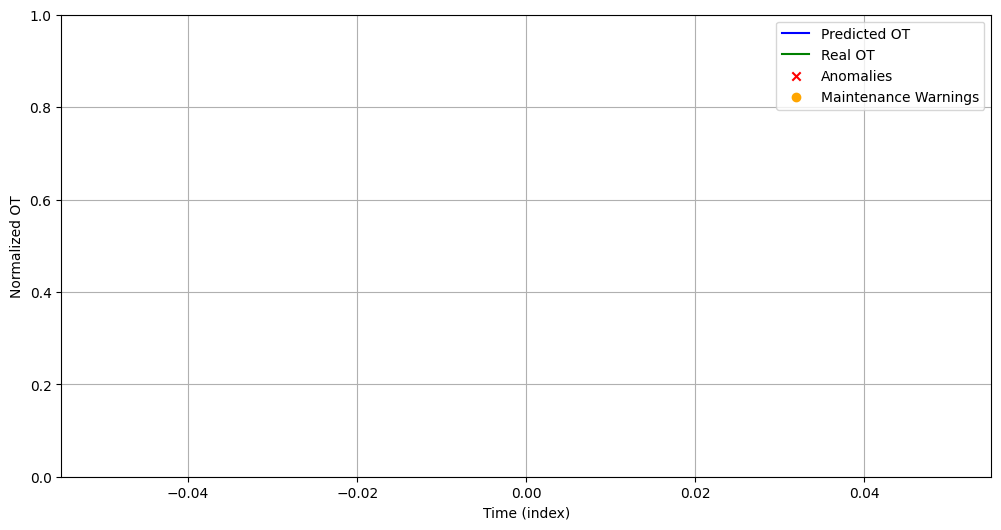

In [45]:
# Data for plotting

# Initialize the plot
plt.ion()  # Interactive mode on
fig, ax = plt.subplots(figsize=(12, 6))
line_pred, = ax.plot([], [], label="Predicted OT", color='blue')
line_real, = ax.plot([], [], label="Real OT", color='green')
scatter_anomalies = ax.scatter([], [], color='red', marker='x', label="Anomalies")
scatter_maintenance = ax.scatter([], [], color='orange', marker='o', label="Maintenance Warnings")
ax.set_ylim(0, 1)
ax.set_xlabel("Time (index)")
ax.set_ylabel("Normalized OT")
ax.legend()
ax.grid()

# Initialize lists
times = []
predicted_ots = []
real_ots = []
anomalies = []
maintenance_alerts = []

In [ ]:

# 🚀 FastAPI Server URL
fastapi_url = "http://localhost:8000/predict"

# 🧠 Rolling window for 96 sensor readings
rolling_window = []

# Stream data row by row
for idx, row in df_etth2.iterrows():
    # Update rolling window with the new data
    ot_value = row['OT']
    rolling_window.append(ot_value)

    if idx + 1 < len(df_etth2):  # Prevent index out of range
        next_row = df_etth2.iloc[idx + 1]
    else:
        next_row = None

    # Keep the last 96 points in the rolling window
    if len(rolling_window) > 96:
        rolling_window.pop(0)

    if len(rolling_window) == 96:
        payload = {"sensor_values": rolling_window}

        try:
            # Send the request
            response = requests.post(fastapi_url, json=payload)
            response.raise_for_status()
            preds = response.json()

            real_ot = next_row['OT'] if next_row is not None else None
            pred_ot = preds['Final_Ensembled_Prediction']

            # Append the data
            times.append(idx)
            predicted_ots.append(pred_ot)
            real_ots.append(real_ot)

            # Anomaly detection
            if real_ot is not None:
                error = abs(pred_ot - real_ot)
                anomaly_detected = error > 0.1  # single boolean value
            else:
                anomaly_detected = False  # fallback if there's no real OT

            if anomaly_detected:
                anomalies.append(idx)

            # Predictive maintenance
            predictive_maintenance = pred_ot > 0.8  # Single boolean value
            if predictive_maintenance:
                maintenance_alerts.append(len(times) - 1)

            # Live plot updates
            line_pred.set_data(times, predicted_ots)
            line_real.set_data(times, real_ots)

            # Update anomalies and maintenance warnings
            anomaly_points = np.array([[i, real_ots[i]] for i in anomalies if i < len(real_ots)])
            if len(anomaly_points) > 0:
                scatter_anomalies.set_offsets(anomaly_points)

            maintenance_points = np.array([[i, predicted_ots[i]] for i in maintenance_alerts])
            if len(maintenance_points) > 0:
                scatter_maintenance.set_offsets(maintenance_points)

            # Recalculate axis limits and scale
            ax.relim()
            ax.autoscale_view()

            # Pause to allow plot to update
            plt.pause(0.01)

            # Debug: Print current time and predictions
            print(f"Time: {row['date']} | Real OT: {real_ot} | Predicted OT: {pred_ot}")

            # Store results
            result_row = {
                "Time": row['date'],
                "Real OT": real_ot,
                "Predicted OT": pred_ot,
                "Anomaly Detected": anomaly_detected,
                "Predictive Maintenance": predictive_maintenance,
                "Energy Efficiency": pred_ot < 0.6,
                "LSTM Prediction": preds['LSTM_Prediction'],
                "PatchTST Prediction": preds['PatchTST_Prediction'],
                "LLM Prediction": preds['LLM_Prediction']
            }

            # Append to DataFrame and write to Excel
            result_df = pd.DataFrame([result_row])
            with pd.ExcelWriter("../data/results/prediction_results.xlsx", mode='a', if_sheet_exists='overlay', engine='openpyxl') as writer:
                result_df.to_excel(writer, index=False, header=writer.sheets.get('Sheet1') is None, startrow=writer.sheets.get('Sheet1').max_row if writer.sheets.get('Sheet1') else 0)

        except requests.exceptions.RequestException as e:
            print(f"❌ Request failed: {e}")

    # Sleep for 1 second to simulate real-time data
    time.sleep(1)

plt.ioff()  # Turn off interactive mode
plt.show()

print(f"\n✅ Results saved to {'../data/results/prediction_results.xlsx'} successfully!")

Time: 2016-07-04 23:00:00 | Real OT: 0.7085970597196581 | Predicted OT: 0.707173764705658
Time: 2016-07-05 00:00:00 | Real OT: 0.6998123344417234 | Predicted OT: 0.703687846660614
Time: 2016-07-05 01:00:00 | Real OT: 0.6910475634570326 | Predicted OT: 0.6963176131248474
Time: 2016-07-05 02:00:00 | Real OT: 0.6603310135451951 | Predicted OT: 0.6947470307350159
Time: 2016-07-05 03:00:00 | Real OT: 0.6559486470932061 | Predicted OT: 0.6745405793190002
Time: 2016-07-05 04:00:00 | Real OT: 0.6691057616765079 | Predicted OT: 0.6755240559577942
Time: 2016-07-05 05:00:00 | Real OT: 0.6822628762598101 | Predicted OT: 0.6805121302604675
Time: 2016-07-05 06:00:00 | Real OT: 0.7042046780403347 | Predicted OT: 0.683861255645752
Time: 2016-07-05 07:00:00 | Real OT: 0.7129794261716473 | Predicted OT: 0.7013745903968811
Time: 2016-07-05 08:00:00 | Real OT: 0.7129794261716473 | Predicted OT: 0.7131176590919495
Time: 2016-07-05 09:00:00 | Real OT: 0.748078342535474 | Predicted OT: 0.7144764065742493
Tim

KeyboardInterrupt: 